In [1]:
# This code follows examples from: https://github.com/NREL/hsds-examples

# To install rex and h5py, see instructions at: https://nrel.github.io/rex/index.html

# environment.yml file that should come with this notebook is written to get all prerequisites 
# and should be the preferred way to establish the environment 
# (it will help consistency across work by team members)

import h5pyd
import pandas as pd
import dateutil
from random import randrange
import rex
import cartopy.crs as ccrs

class InvalidUsage(Exception):
    status_code = 400

    def __init__(self, message, status_code=None, payload=None):
        Exception.__init__(self)
        self.message = message
        if status_code is not None:
            self.status_code = status_code
        self.payload = payload

    def to_dict(self):
        rv = dict(self.payload or ())
        rv['message'] = self.message
        return rv

def available_datasets(f):
    """ Return list of all datasets available in resource f.
    """
    try:
        datasets = sorted(list(f))
    except ValueError:
        raise InvalidUsage("Problem with processing WTK datasets.")
    return datasets

endpoint = "https://developer.nrel.gov/api/hsds"
domain = "/nrel/wtk-us.h5"
username = None
password = None
# This is public key; it has usage limitations but should be good for development & testing
api_key = "3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf"

try:
    hsds_f = h5pyd.File(domain=domain,
                   endpoint=endpoint,
                   username=username,
                   password=password,
                   api_key=api_key,
                   mode='r')

except OSError:
    raise InvalidUsage("Failed to access HSDS resource", status_code=403)

print("\nPrinting list of available datasets:")
print(available_datasets(hsds_f))

print("\nPrinting small sample of windspeed data (3 values, first one should be: 10.68148):")
dset = hsds_f["windspeed_60m"]

# First argument -- range of timesteps corresponding to time indices (see the next cell);
# second and third -- indices corresponding to lat,lon pairs in the coordinates array
print(dset[420:420+3, 42, 42])


Printing list of available datasets:
['DIF', 'DNI', 'GHI', 'coordinates', 'datetime', 'inversemoninobukhovlength_2m', 'precipitationrate_0m', 'pressure_0m', 'pressure_100m', 'pressure_200m', 'relativehumidity_2m', 'status', 'temperature_100m', 'temperature_10m', 'temperature_120m', 'temperature_140m', 'temperature_160m', 'temperature_200m', 'temperature_2m', 'temperature_40m', 'temperature_60m', 'temperature_80m', 'winddirection_100m', 'winddirection_10m', 'winddirection_120m', 'winddirection_140m', 'winddirection_160m', 'winddirection_200m', 'winddirection_40m', 'winddirection_60m', 'winddirection_80m', 'windspeed_100m', 'windspeed_10m', 'windspeed_120m', 'windspeed_140m', 'windspeed_160m', 'windspeed_200m', 'windspeed_40m', 'windspeed_60m', 'windspeed_80m']

Printing small sample of windspeed data (3 values, first one should be: 10.68148):
[10.68148  10.650963 10.821861]


In [2]:
def time_indices_all(f):
    """ Returns a dataframe with all processed timestamps from HSDS resource f"""
    dt = f["datetime"]
    dt = pd.DataFrame({"datetime": dt[:]}, index=range(0, dt.shape[0]))
    dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)
    return dt

time_df = time_indices_all(hsds_f)
print(time_df)

                 datetime
0     2007-01-01 00:00:00
1     2007-01-01 01:00:00
2     2007-01-01 02:00:00
3     2007-01-01 03:00:00
4     2007-01-01 04:00:00
...                   ...
61363 2013-12-31 19:00:00
61364 2013-12-31 20:00:00
61365 2013-12-31 21:00:00
61366 2013-12-31 22:00:00
61367 2013-12-31 23:00:00

[61368 rows x 1 columns]


In [3]:
# Example of subsetting based on time index; 2-year example

start_t = pd.to_datetime('20100101', format='%Y%m%d')
end_t = pd.to_datetime('20120101', format='%Y%m%d')
index_list = time_df[(time_df.datetime >= start_t) & (time_df.datetime <= end_t)].index
start_idx = index_list.min()
end_idx = index_list.max()

print("Selected time interval corresponds to time indicies in the range between:")
print(start_idx, end_idx)

Selected time interval corresponds to time indicies in the range between:
26304 43824


In [4]:
# Request data for a particular location (defined by a pair of indicies: (42,42)

dset = hsds_f["windspeed_60m"]
values = dset[start_idx:end_idx + 1, 42, 42]

print(values)
print("Stats for extracted values:")
print(pd.Series(values).describe())

[10.09552   12.027344  11.42308   ...  4.660179   5.368202   4.7975082]
Stats for extracted values:
count    17521.000000
mean         6.733769
std          2.163086
min          0.128181
25%          5.282753
50%          6.756798
75%          8.178963
max         15.594955
dtype: float64


In [5]:
%%timeit

# This cell helps to see how fast this query is;
# every time we run this, a new location in the array will be used to avoid potential effects of caching on the HSDS side;
# %%timeit needs to be at the very top of the cell; by default it times 7 executions of the code in the cell

idx = randrange(1500)  
dset = hsds_f["windspeed_60m"]
values = dset[start_idx:end_idx + 1, idx, idx]

# My result here: 5.33 s ± 1.19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

3.03 s ± 585 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### More Efficient Code for Multi-Year Queries

In [6]:
# Code below will use a class from the rex package:
# https://nrel.github.io/rex/rex/rex.multi_year_resource.html#rex.multi_year_resource.MultiYearResource

In [7]:
from rex.multi_year_resource import * 

myr = MultiYearWindResource('/nrel/wtk/conus/wtk_conus_*.h5', hsds=True)
# To see what is available inside this object/class, type `help(myr)` in a separate cell

In [8]:
# This is how coordinates can be accessed
myr.coordinates[0:5]

array([[  37.603382, -127.61705 ],
       [  37.62042 , -127.62601 ],
       [  37.63745 , -127.63498 ],
       [  37.654484, -127.64395 ],
       [  37.67151 , -127.65292 ]], dtype=float32)

In [9]:
# This is how time index can be accessed
myr.time_index[0:5]

DatetimeIndex(['2007-01-01 00:00:00+00:00', '2007-01-01 01:00:00+00:00',
               '2007-01-01 02:00:00+00:00', '2007-01-01 03:00:00+00:00',
               '2007-01-01 04:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

In [10]:
# Just like in the example above, we can subset based on the time interval of interest

dt = myr.time_index
dt = pd.DataFrame({"datetime": dt[:]}, index=range(0, dt.shape[0]))
start_t = pd.to_datetime('20100101', format='%Y%m%d').tz_localize('UTC') 
end_t = pd.to_datetime('20120101', format='%Y%m%d').tz_localize('UTC') 
index_list = dt[(dt.datetime >= start_t) & (dt.datetime <= end_t)].index
start_idx = index_list.min()
end_idx = index_list.max()

print("Selected time interval corresponds to time indicies in the range between:")
print(start_idx, end_idx)

Selected time interval corresponds to time indicies in the range between:
26304 43824


In [11]:
values = myr['windspeed_60m', start_idx:end_idx+1, 3]

print(values)
print("Stats for extracted values:")
print(pd.Series(values).describe())

[14.16 14.14 13.58 ...  3.54  3.73  4.06]
Stats for extracted values:
count    17521.000000
mean         9.161532
std          3.701231
min          0.140000
25%          6.500000
50%          9.000000
75%         11.700000
max         23.620001
dtype: float64


In [12]:
%%timeit

idx = randrange(500)  
values = myr['windspeed_60m', start_idx:end_idx+1, idx]

# My result here: 720 ms ± 46.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Great Improvement! This is more than 5x faster than the method used above (without rex)

# The key difference isn't the interface but rather the fact the domain '/nrel/wtk/conus/wtk_conus_*.h5' 
# is used here instead of: '/nrel/wtk-us.h5'; 
# the former is optimized for longer queries

705 ms ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit 

idx = randrange(500)
values = myr['windspeed_60m', :, idx]

# My result here for queries for all 7 years: 
# 2.07 s ± 189 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Conclusion: scaling here isn't linear, i.e. querying 7 years is faster than querying 1 year 7 times.

2.27 s ± 416 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Making sense of coordinates

In [14]:
from rex.resource_extraction import *

# This is a bit different than the code above; MultiYearWindX is used instead of 
# MultiYearWindResource to access cKDTree object and 
# find grid points that are the closest to the location of interest

myr = MultiYearWindX('/nrel/wtk/conus/wtk_conus_*.h5', hsds=True)
# To see what is available inside this object/class, type `help(myr)` in a separate cell

In [15]:
# Find indices of N=4 grid points that are the closest to the site (dd will be distances from the site)
NewYorkPoint = (40.7484, -73.9857)

dd,ii = myr.tree.query(NewYorkPoint, 4)
print(dd,ii)

print(myr.coordinates[ii])

[0.00688171 0.0175041  0.0196696  0.0208428 ] [2301508 2300566 2301509 2301507]
[[ 40.74543  -73.97949 ]
 [ 40.75046  -74.00308 ]
 [ 40.763283 -73.97284 ]
 [ 40.727562 -73.986145]]


In [16]:
# This is essentially Nearest-Neighbor interpolaton -- extracting wind speed values for the grid point 
# that is the closest to the specified location
values = myr['windspeed_60m', :, ii[0]]

print(values)
print("Stats for extracted values:")
print(pd.Series(values).describe())

# Performance here should be as good as what we say above with MultiYearWindResource (e.g., ~2s for 7 years)

[3.38 2.64 3.2  ... 6.14 6.59 6.47]
Stats for extracted values:
count    70128.000000
mean         5.342026
std          2.691895
min          0.040000
25%          3.390000
50%          5.020000
75%          6.940000
max         26.240000
dtype: float64


In [17]:
def coordXform(orig_crs, target_crs, x, y):
    return target_crs.transform_points(orig_crs, x, y)

crs_from = ccrs.PlateCarree()

# This projection uses USA_Contiguous_Albers_Equal_Area_Conic_USGS_version:
# typical projection for historical USGS maps of the lower 48
# Reference: https://spatialreference.org/ref/sr-org/usa_contiguous_/
# albers_equal_area_conic_usgs_version-2/
crs_to = ccrs.AlbersEqualArea(central_longitude=-96.0,
                              central_latitude=23.0,
                              false_easting=0.0,
                              false_northing=0.0,
                              standard_parallels=(29.5, 45.5), globe=None)

center_lat_lon = NewYorkPoint
neighbors_lat_lon = myr.coordinates[ii]

center_xy = coordXform(crs_from, crs_to, np.array([center_lat_lon[0]]), np.array([center_lat_lon[1]]) )[0]
#print(center_xy)

neighbors_xy = coordXform(crs_from, crs_to, 
                          np.array([x[0] for x in neighbors_lat_lon]), 
                          np.array([x[1] for x in neighbors_lat_lon]))
#print(neighbors_xy)

res = pd.DataFrame(columns=["idx", "lat", "lon",
                    "x_centered", "y_centered", "d"])
for idx, latlon, xy in zip(ii, neighbors_lat_lon, neighbors_xy):

    # Distance in meters calculated after applying projections
    dx = xy[0] - center_xy[0]
    dy = xy[1] - center_xy[1]
    d = np.sqrt(dx ** 2 + dy ** 2)
    res.loc[len(res)] = [idx, latlon[0], latlon[1], dx, dy, d]

res["idx"] = pd.to_numeric(res["idx"], downcast='integer')
trim = 4
res = res.sort_values("d")[:trim].reset_index(drop=True)

display(res)

,idx,lat,lon,x_centered,y_centered,d
0,2300566,40.750462,-74.003082,383.814698,315.528573,496.862157
1,2301508,40.745430,-73.979492,-188.909382,-502.825787,537.141068
2,2301509,40.763283,-73.972839,95.638416,2632.502484,2634.239176
3,2301507,40.727562,-73.986145,-474.456356,-3640.782814,3671.567558


### Quick Analysis for Heidi -- looking at wind at a specific location

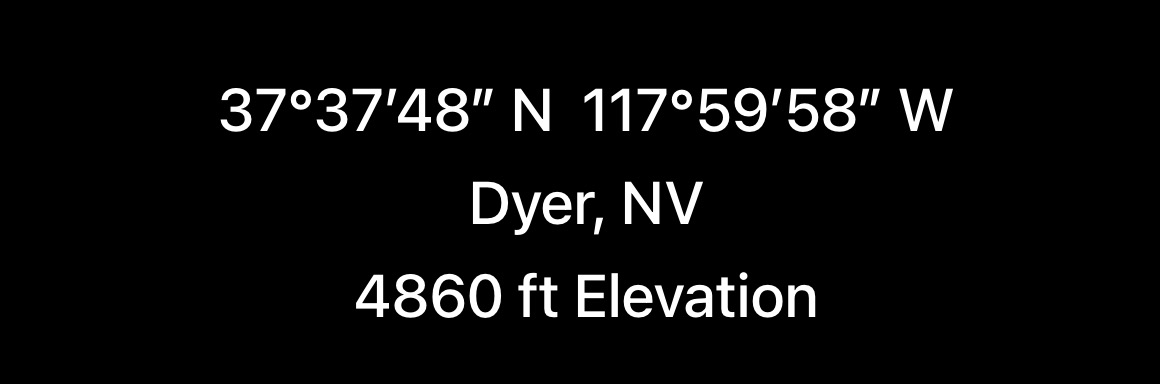

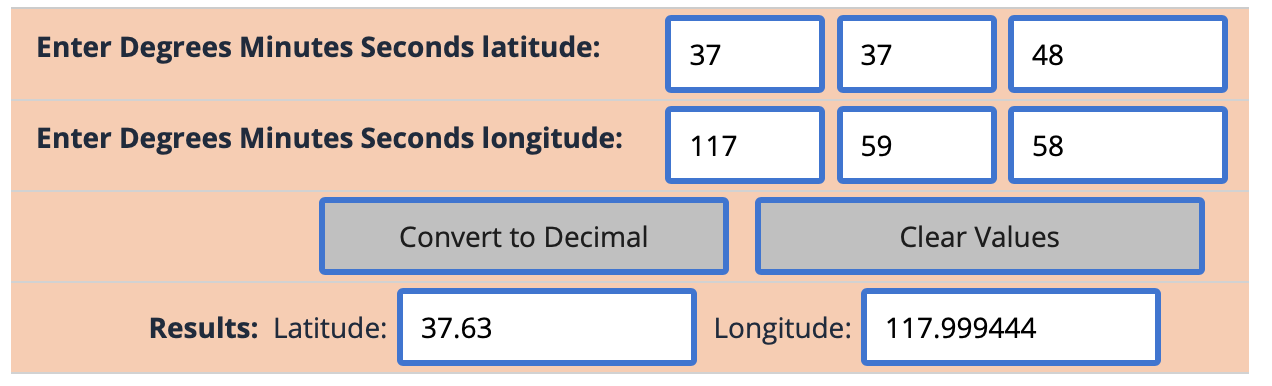

In [18]:
site_location = (37.63, -117.999444)

dd,ii = myr.tree.query(site_location, 1)

print(dd,ii)
print(myr.coordinates[ii])

0.005942145787539044 320794
[  37.63302 -118.00456]


In [19]:
# This is essentially Nearest-Neighbor interpolaton -- extracting wind speed values for the grid point 
# that is the closest to the specified location
site_wind = myr['windspeed_40m', :, ii]

print(site_wind)
print("Stats for extracted values:")
site_wind_df = pd.DataFrame({"wind_ms": site_wind})
print(site_wind_df.describe())

[ 7.61  9.07 10.08 ...  9.97 10.47 10.39]
Stats for extracted values:
            wind_ms
count  70128.000000
mean       5.697566
std        3.779223
min        0.020000
25%        2.450000
50%        5.400000
75%        8.160000
max       24.309999


In [20]:
site_wind_df["wind_ms_rounded"] = site_wind_df["wind_ms"].apply(lambda x: int(x))
site_wind_df.head()

,wind_ms,wind_ms_rounded
0,7.61,7
1,9.07,9
2,10.08,10
3,8.16,8
4,7.52,7


<AxesSubplot:>

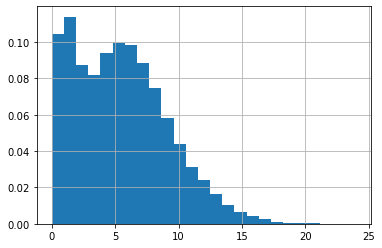

In [21]:
site_wind_df.wind_ms_rounded.hist(bins=site_wind_df.wind_ms_rounded.nunique(), density=True)

### Create windrose

In [23]:
site_speed = myr['windspeed_40m', :, ii]
site_direction = myr['winddirection_40m', :, ii]

site_wind = pd.DataFrame({"speed": site_speed, "direction": site_direction})
print(site_wind.head())

   speed   direction
0   7.61  322.600006
1   9.07  318.779999
2  10.08  317.869995
3   8.16  319.750000
4   7.52  310.429993


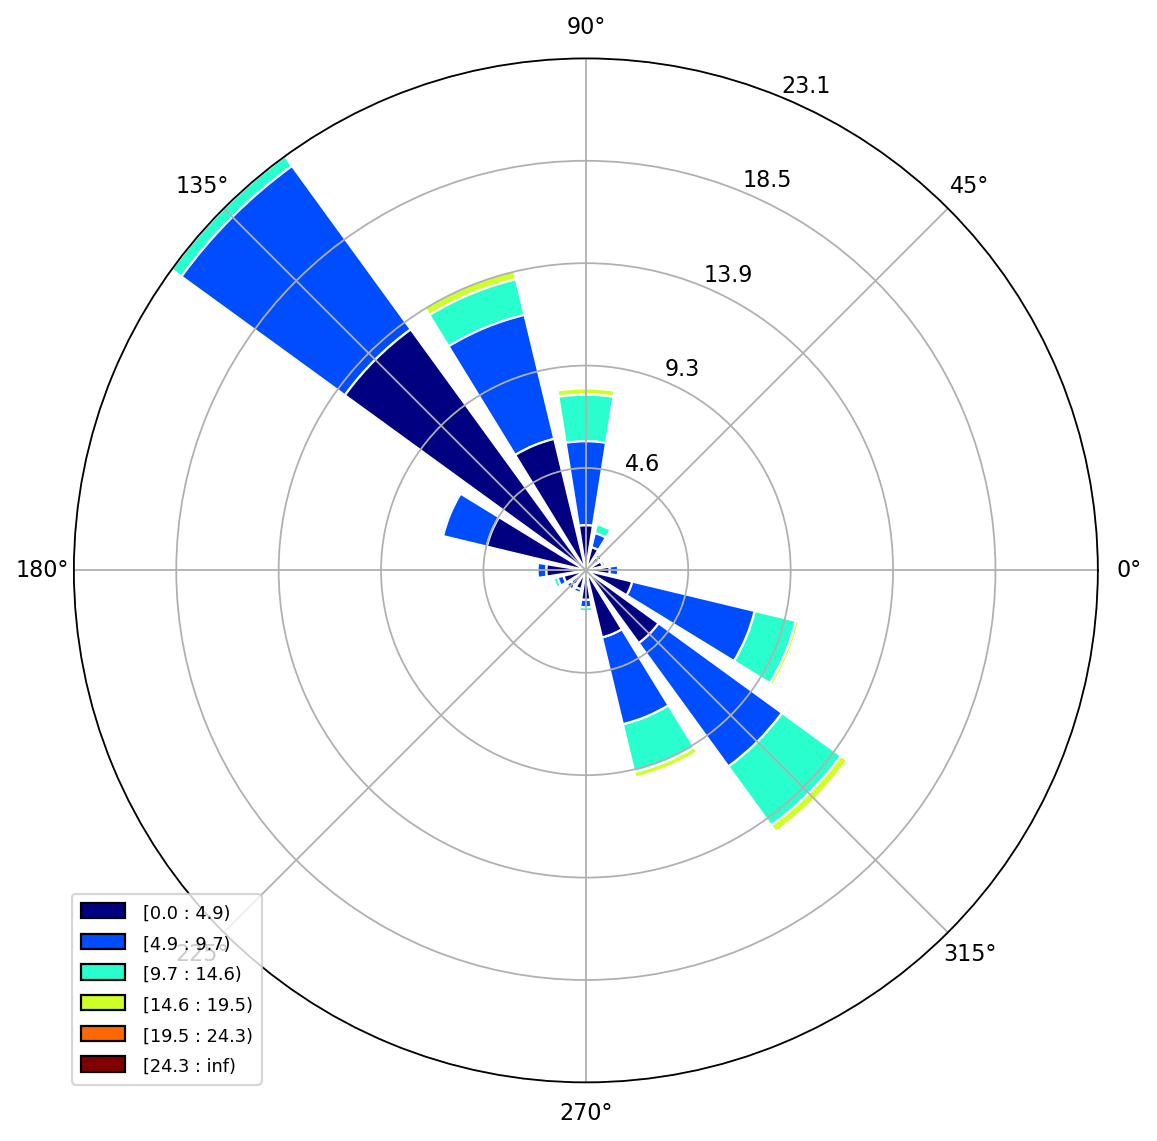

In [29]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

%config InlineBackend.figure_format = 'retina'

ax = WindroseAxes.from_ax()
ax.bar(site_wind.direction, site_wind.speed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend();